In [34]:
import pandas as pd
import warnings
from lifelines import CoxPHFitter, CoxTimeVaryingFitter
import re
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/base_modelis_pass_det.csv',sep = ';')

In [3]:
df['date_entree_defaut'] = pd.to_datetime(df['date_entree_defaut'], format='%d/%m/%y')
df['date_sortie_defaut'] = pd.to_datetime(df['date_sortie_defaut'], format='%d/%m/%y', errors='coerce')
df['arrete'] = pd.to_datetime(df['arrete'], format='%d/%m/%y')
df['DT_MEP_OPE'] = pd.to_datetime(df['DT_MEP_OPE'], format='%d%b%Y:%H:%M:%S.%f')
df['dt_arr_last_enc_ope'] = pd.to_datetime(df['dt_arr_last_enc_ope'], errors='coerce')
df['dt_arr_1st_enc_ope'] = pd.to_datetime(df['dt_arr_1st_enc_ope'], errors='coerce')
df['dtHJD_prov'] = pd.to_datetime(df['dtHJD_prov'], errors='coerce')
df['dtHJD_def'] = pd.to_datetime(df['dtHJD_def'], errors='coerce')

In [4]:
for column in df.columns :
    if df[column].isna().sum()/df.shape[0] > 0.5 : 
        df.drop(columns = [column], inplace = True)

In [5]:
df.drop(columns = ["CD_POST_BIEN_PFI"], inplace = True)

In [6]:
cols_numeriques = df.select_dtypes(include=['float64', 'int64']).columns.to_list()
cols_categorielles = df.select_dtypes(include=['object']).columns.to_list()
cols_categorielles.remove("cd_op")

for col in cols_numeriques:
    df[col].fillna(df[col].mean(), inplace=True)

for col in cols_categorielles:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [7]:
df_validation = df[df['arrete']>"2020-12-30"]
df_train = df[df['arrete']<"2020-12-30"]
df_train = df_train.reset_index()

In [8]:
liste_var = ['fam_ENQ','solution','FL_REL_NON_ANNULE','niv_gravite_mtf_dne','CD_SITFAM_EMP1','regroup_natur_op','PTG','fl_fam_vam','fam_PCD','AMI','CD_ETAT_CIVIL','CD_NAT_EMP1','niv_gravite_mtf_dne','FL_REL_NON_ANNULE','sol_echec','fl_def_ss_pass_CTX','nb_empr_ope','CD_MTF_DFC','FL_ETR']

In [9]:
df_train_var = df[liste_var].copy()
df_test_var = df_validation[liste_var].copy()

# Encoding

In [10]:
def encode_columns(df):
    encoders = {}
    for column in df.select_dtypes(include='object'):
        unique_values = df[column].nunique()
        if unique_values <= 10:
            # Appliquer OneHotEncoder
            encoder = OneHotEncoder(sparse=False)
            encoded = encoder.fit_transform(df[[column]])
            encoders[column] = encoder

            # Remplacer la colonne originale par de nouvelles colonnes pour chaque catégorie
            for i, category in enumerate(encoder.categories_[0]):
                df[str(column) + '_' + str(category)] = encoded[:, i]
            df.drop(column, axis=1, inplace=True)
        else:
            # Appliquer LabelEncoder
            encoder = LabelEncoder()
            df[column] = encoder.fit_transform(df[column])
            encoders[column] = encoder
    return df, encoders

encoded_df, encoders = encode_columns(df_train_var)
encoded_test, encoder_test = encode_columns(df_test_var)

In [11]:
df_train_var['cd_op']  = df['cd_op'].copy()
df_train_var['fl_pass_DET'] = df['fl_pass_DET'].copy()
df_train_var['date_entree_defaut'] = df['date_entree_defaut'].copy()
df_train_var['arrete'] = df['arrete'].copy()

In [12]:
df_test_var['cd_op']  = df_validation['cd_op'].copy()
df_test_var['fl_pass_DET'] = df_validation['fl_pass_DET'].copy()
df_test_var['date_entree_defaut'] = df_validation['date_entree_defaut'].copy()
df_test_var['arrete'] = df_validation['arrete'].copy()

# DataPrep

In [13]:
data_haz = df_train_var.copy()
data_test =df_test_var.copy()

In [14]:
data_haz['start'] = 0
data_haz['stop'] = data_haz['arrete'] - data_haz['date_entree_defaut']
data_haz['stop'] = data_haz['stop'].dt.days

data_test['start'] = 0
data_test['stop'] = data_test['arrete'] - data_test['date_entree_defaut']
data_test['stop'] = data_test['stop'].dt.days

In [15]:
data_haz['id'] = data_haz['cd_op'].apply(lambda x: re.sub(r'\D', '', str(x)))


data_test['id'] = data_test['cd_op'].apply(lambda x: re.sub(r'\D', '', str(x)))

In [16]:
data_haz.id = data_haz.id.astype('int')

In [17]:
data_haz.loc[(data_haz['start'] == data_haz['stop']) & (data_haz['start'] == 0) & data_haz[
    'fl_pass_DET'], 'stop'] = 0.5  # car le modele n'accepte pas les individus qui sortent de la survie au moment ou ils y entrent donc on remplace les 0 par 0.5.

data_test.loc[(data_test['start'] == data_test['stop']) & (data_test['start'] == 0) & data_test[
    'fl_pass_DET'], 'stop'] = 0.5 

In [18]:
data_haz = data_haz.select_dtypes(exclude=["datetime64"])

data_test = data_test.select_dtypes(exclude=["datetime64"])

In [19]:
data_haz.drop(columns = ["cd_op"], inplace = True)


data_test.drop(columns = ["cd_op"], inplace = True)

# Modelisation

In [89]:
ctv = CoxTimeVaryingFitter(penalizer=0.1)
ctv.fit(data_haz, id_col="id", event_col="fl_pass_DET", stop_col="stop", show_progress=True)

KeyboardInterrupt: 

In [ ]:
ctv.print_summary()

On va drop fam_enq et cd_etat_civil car cd_etat_civil est non significative et fam_enq a l'air de faire buguer le modèle

#### Tests pour voir quelles var soont problematiques

In [ ]:
for col in [ 'fl_def_ss_pass_CTX',
       'nb_empr_ope', 'CD_MTF_DFC', 'FL_ETR', 'CD_SITFAM_EMP1_C',
       'CD_SITFAM_EMP1_D', 'CD_SITFAM_EMP1_I', 'CD_SITFAM_EMP1_M',
       'CD_SITFAM_EMP1_S', 'CD_SITFAM_EMP1_U', 'CD_SITFAM_EMP1_V',
       'regroup_natur_op_1_neuf_aco_acr', 'regroup_natur_op_2_rachat_sou',
       'regroup_natur_op_3_travaux', 'regroup_natur_op_4_autre',
       'CD_NAT_EMP1_CDT', 'CD_NAT_EMP1_CEE', 'CD_NAT_EMP1_ETR',
       'CD_NAT_EMP1_FRA', 'CD_NAT_EMP1_ZZZ', 'sol_echec_0_0', 'sol_echec_0_1',
       'sol_echec_1_0', 'sol_echec_1_1'] : 
    print(f"{col}")
    ctv3 = CoxTimeVaryingFitter(penalizer=0.1)
    ctv3.fit(data_haz[[col,'id','fl_pass_DET','stop','start']], id_col="id", event_col="fl_pass_DET", stop_col="stop", show_progress=True, start_col='start')
    ctv3.plot()

liste var problematiques : FL_REL_NON_ANNULE, 'niv_gravite_mtf_dne' 'niv_gravite_mtf_dne'

# Modèle V2

In [20]:
data_haz2 = data_haz[[ 'fl_def_ss_pass_CTX',
       'nb_empr_ope', 'CD_MTF_DFC', 'FL_ETR', 'CD_SITFAM_EMP1_C',
       'CD_SITFAM_EMP1_D', 'CD_SITFAM_EMP1_I', 'CD_SITFAM_EMP1_M',
       'CD_SITFAM_EMP1_S', 'CD_SITFAM_EMP1_U', 'CD_SITFAM_EMP1_V',
       'regroup_natur_op_1_neuf_aco_acr', 'regroup_natur_op_2_rachat_sou',
       'regroup_natur_op_3_travaux', 'regroup_natur_op_4_autre',
       'CD_NAT_EMP1_CDT', 'CD_NAT_EMP1_CEE', 'CD_NAT_EMP1_ETR',
       'CD_NAT_EMP1_FRA', 'CD_NAT_EMP1_ZZZ', 'sol_echec_0_0', 'sol_echec_0_1',
       'sol_echec_1_0', 'sol_echec_1_1','id','fl_pass_DET','stop','start']]


data_test2 = data_test[[ 'fl_def_ss_pass_CTX',
       'nb_empr_ope', 'CD_MTF_DFC', 'FL_ETR', 'CD_SITFAM_EMP1_C',
       'CD_SITFAM_EMP1_D', 'CD_SITFAM_EMP1_I', 'CD_SITFAM_EMP1_M',
       'CD_SITFAM_EMP1_S', 'CD_SITFAM_EMP1_U', 'CD_SITFAM_EMP1_V',
       'regroup_natur_op_1_neuf_aco_acr', 'regroup_natur_op_2_rachat_sou',
       'regroup_natur_op_3_travaux', 'regroup_natur_op_4_autre',
       'CD_NAT_EMP1_CDT', 'CD_NAT_EMP1_CEE', 'CD_NAT_EMP1_ETR',
       'CD_NAT_EMP1_FRA', 'CD_NAT_EMP1_ZZZ', 'sol_echec_0_0', 'sol_echec_0_1',
       'sol_echec_1_0', 'sol_echec_1_1','id','fl_pass_DET','stop','start']]

#ctv2 = CoxTimeVaryingFitter(penalizer=0.1)
#ctv2.fit(data_haz2, id_col="id", event_col="fl_pass_DET", stop_col="stop", show_progress=True)

In [ ]:
#ctv2.plot()

# Test CoxPHFitter

In [58]:
data_haz.head(30)

,fam_ENQ,solution,FL_REL_NON_ANNULE,niv_gravite_mtf_dne,PTG,fl_fam_vam,fam_PCD,AMI,CD_ETAT_CIVIL,niv_gravite_mtf_dne,...,CD_NAT_EMP1_FRA,CD_NAT_EMP1_ZZZ,sol_echec_0_0,sol_echec_0_1,sol_echec_1_0,sol_echec_1_1,fl_pass_DET,start,stop,id
0,0,0,0,2.0,0.109152,0,0,0.595968,7,2.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0,0,15.0,860708600
1,0,0,0,2.0,0.109152,0,0,0.595968,7,2.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0,0,43.0,860708600
2,0,0,0,2.0,0.109152,0,0,0.595968,7,2.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0,0,74.0,860708600
3,0,0,0,2.0,0.109152,0,0,0.595968,7,2.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0,0,104.0,860708600
4,0,0,0,2.0,0.109152,0,0,0.595968,7,2.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0,0,135.0,860708600
5,0,0,0,2.0,0.109152,0,0,0.595968,7,2.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0,0,165.0,860708600
6,0,0,0,2.0,0.109152,0,0,0.595968,7,2.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0,0,196.0,860708600
7,0,0,0,2.0,0.109152,0,0,0.595968,7,2.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0,0,227.0,860708600
8,0,0,0,2.0,0.109152,0,0,0.595968,7,2.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0,0,257.0,860708600
9,0,0,0,2.0,0.109152,0,0,0.595968,7,2.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0,0,288.0,860708600


In [21]:
data_cox = data_haz2.drop_duplicates(subset = "id",keep = 'last') # on retire les doublons
test_cox = data_test2.drop_duplicates(subset = "id",keep = 'last') # on retire les doublons
test_cox.drop(columns = ['start','fl_pass_DET', 'id'],inplace = True )

In [22]:
from lifelines import CoxPHFitter

cph = CoxPHFitter(penalizer=0.1)  # Choisir le paramètre de pénalité
cph.fit(data_haz2.drop(columns = ['id','start']), duration_col='stop', event_col='fl_pass_DET')


<lifelines.CoxPHFitter: fitted with 329064 total observations, 321601 right-censored observations>

In [23]:
predictions = cph.predict_survival_function(test_cox)


In [51]:
predictions = predictions.transpose()

In [56]:
predictions.shape

(10614, 2332)

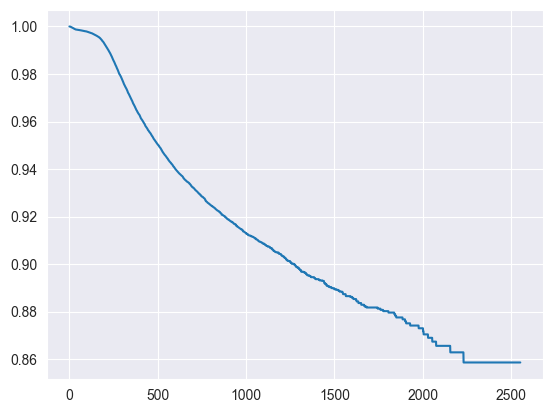

In [55]:
survival_function_observation_0 = predictions.iloc[10]

# Tracer la fonction de survie pour l'observation 0
survival_function_observation_0.plot()
plt.show()